In [1]:
# # Install the latest version of author's repo neural ode implementation
# !git clone https://github.com/rtqichen/torchdiffeq.git
# !cd torchdiffeq && pip install -e .
# !ls torchdiffeq/torchdiffeq

In [1]:
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, 4).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = ['week(t-4)', 'week(t-3)', 'week(t-2)', 'week(t-1)', 'week(t)']).head(20))

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(502, 5)
    week(t-4)  week(t-3)  week(t-2)  week(t-1)   week(t)
0    6.522572   6.432569   6.384427   6.225123  5.997283
1    6.432569   6.384427   6.225123   5.997283  6.049106
2    6.384427   6.225123   5.997283   6.049106  6.187098
3    6.225123   5.997283   6.049106   6.187098  6.240301
4    5.997283   6.049106   6.187098   6.240301  6.642778
5    6.049106   6.187098   6.240301   6.642778  6.888709
6    6.187098   6.240301   6.642778   6.888709  6.890396
7    6.240301   6.642778   6.888709   6.890396  7.080826
8    6.642778   6.888709   6.890396   7.080826  7.292260
9    6.888709   6.890396   7.080826   7.292260  7.421818
10   6.890396   7.080826   7.292260   7.421818  7.603969
11   7.08082

In [2]:
# size of the data
data_size = data_m1.shape[0]
dim_input = data_m1.shape[1]
# batch time and batch size
batch_time = 6  # time steps ahead that we need to predict, for each training sample
train_size = int(0.8*data_size)  # training size
print(f"training size is {train_size}")
test_size = data_size - train_size
print(f"test size is {test_size}")
niters = 2000  # training epochs
test_freq = 50
viz = True

training size is 401
test size is 101


In [3]:
# Convert to tensor
# https://pytorch.org/docs/stable/generated/torch.from_numpy.html
data_torch = torch.from_numpy(data_m1)  # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
# true_y.shape
# Reshape it to get in (m, 1, dim_input)
data_torch = torch.reshape(data_torch, (data_size, 1, dim_input))  # https://pytorch.org/docs/stable/generated/torch.reshape.html
print(data_torch.shape)

# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., test_size-batch_time, test_size-batch_time)
print(t.shape)

# # Initial value
# true_y0 = torch.reshape(true_y[0:batch_size], (batch_size, 1, dim))
# # true_y0


torch.Size([502, 1, 5])
torch.Size([95])


In [12]:
torch.arange(0, train_size-batch_time)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [16]:
torch.arange(train_size, data_size-batch_time)

tensor([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
        471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
        485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495])

In [13]:
def get_batch(mode):
    if mode == 'train':
        # Get mini batches
        s = torch.arange(0, train_size-batch_time)  # https://pytorch.org/docs/stable/generated/torch.arange.html
        # Get the #s initial values from data 
        batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
        # The time steps ahead for each sample
        batch_t = t[:batch_time]  # (T)
        # For each initial value, we will have T values 
        batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
        # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
        return batch_y0, batch_t, batch_y
    elif mode == 'test':
        s = torch.arange(train_size, data_size-batch_time)
        # Get the #s initial values from data 
        batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
        # The time steps ahead for each sample
        batch_t = t[:batch_time]  # (T)
        # For each initial value, we will have T values 
        batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
        # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
    
        return batch_y0, batch_t, batch_y

In [9]:
# s = torch.arange(0, batch_size+0)

In [10]:
# true_y.shape

In [11]:
# true_y[s+5].shape

In [14]:
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
print(train_batch_t.shape)
print(train_batch_y0.shape)
print(train_batch_y.shape)

torch.Size([6])
torch.Size([395, 1, 5])
torch.Size([6, 395, 1, 5])


In [96]:
# torch.reshape(batch_y, (batch_time, batch_size, 1, 1))

In [15]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(dim_input, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, dim_input),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
# func = ODEFunc()

# def visualize(t, true_y, pred_y, odefunc, itr):
  
#     if viz:
      
#         plt.figure()
#         plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-')
#         plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--')
#         # plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
#         plt.show()
        
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [98]:
# batch_y.shape

In [99]:
# pred_y.shape

In [19]:
# training
ii = 0
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
# optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
    pred_y = odeint(func, train_batch_y0, train_batch_t)
    # print(pred_y.shape)
    # loss = torch.mean(torch.abs(pred_y - batch_y))
    loss = torch.nn.MSELoss()(pred_y, train_batch_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr%200==0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            # visualize(batch_t, batch_y, pred_y, func, ii)

    end = time.time()

Iter 0200 | Total Loss 0.806697
Iter 0400 | Total Loss 0.708462
Iter 0600 | Total Loss 0.653461
Iter 0800 | Total Loss 0.729338
Iter 1000 | Total Loss 0.716897
Iter 1200 | Total Loss 0.557879
Iter 1400 | Total Loss 0.591225
Iter 1600 | Total Loss 0.524499
Iter 1800 | Total Loss 0.663366
Iter 2000 | Total Loss 0.547661


In [29]:
# print training loss
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
train_pred_y = odeint(func, train_batch_y0, train_batch_t)
loss = torch.nn.MSELoss()(train_pred_y[5, :, :, :], train_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 1.409471


In [30]:
# testing
test_batch_y0, test_batch_t, test_batch_y = get_batch('test')
test_pred_y = odeint(func, test_batch_y0, test_batch_t)
loss = torch.nn.MSELoss()(test_pred_y[5, :, :, :], test_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 11.852684


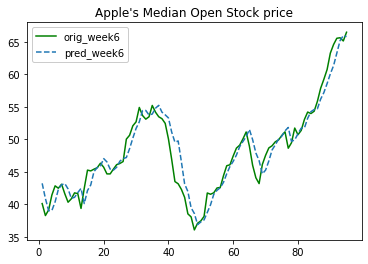

In [34]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


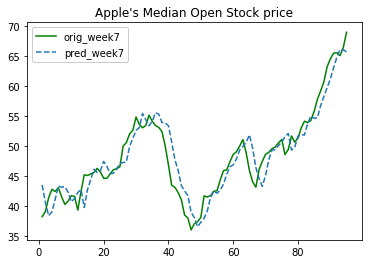

In [39]:
# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


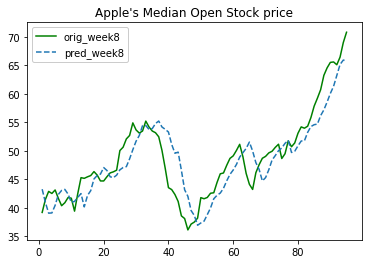

In [40]:
# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 2], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 0], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


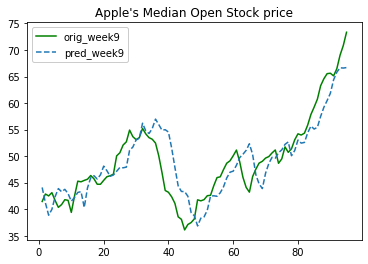

In [41]:
# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 3], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 3], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


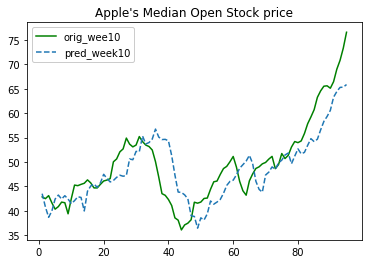

In [42]:
# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 4], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 4], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


## Adam


In [43]:
# training
ii = 0
func = ODEFunc()
# optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
    pred_y = odeint(func, train_batch_y0, train_batch_t)
    # print(pred_y.shape)
    # loss = torch.mean(torch.abs(pred_y - batch_y))
    loss = torch.nn.MSELoss()(pred_y, train_batch_y)  # https://towardsdatascience.com/understanding-pytorch-loss-functions-the-maths-and-algorithms-part-1-6e439b27117e
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr%200==0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            # visualize(batch_t, batch_y, pred_y, func, ii)

    end = time.time()

Iter 0200 | Total Loss 0.535809
Iter 0400 | Total Loss 0.510984
Iter 0600 | Total Loss 0.499075
Iter 0800 | Total Loss 0.491926
Iter 1000 | Total Loss 0.483681
Iter 1200 | Total Loss 0.474271
Iter 1400 | Total Loss 0.453295
Iter 1600 | Total Loss 0.438525
Iter 1800 | Total Loss 0.426511
Iter 2000 | Total Loss 0.414654


In [44]:
# print training loss
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
train_pred_y = odeint(func, train_batch_y0, train_batch_t)
loss = torch.nn.MSELoss()(train_pred_y[5, :, :, :], train_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

# testing
test_batch_y0, test_batch_t, test_batch_y = get_batch('test')
test_pred_y = odeint(func, test_batch_y0, test_batch_t)
loss = torch.nn.MSELoss()(test_pred_y[5, :, :, :], test_batch_y[5, :, :, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 1.081104
Total Loss 12.245694


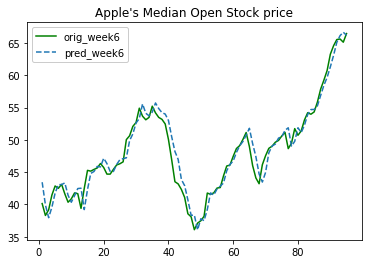

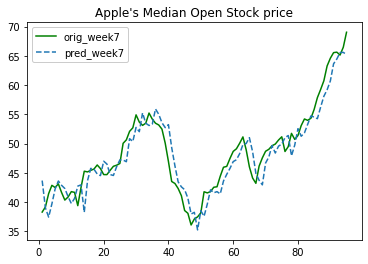

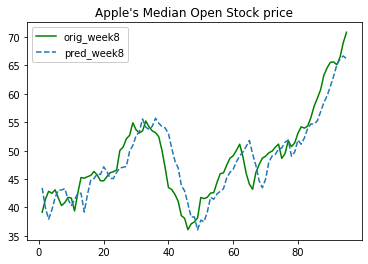

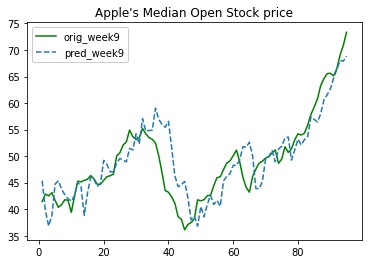

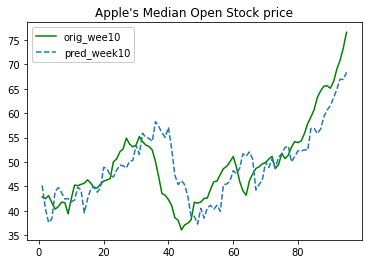

In [45]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 2], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 2], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 3], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 3], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), test_batch_y.numpy()[5, :, 0, 4], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[5, :, 0, 4], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()
